## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from problems import problem_OP

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

mean-parma1 =  0.3720654037899112      mean-param2 =  0.21902819231692378


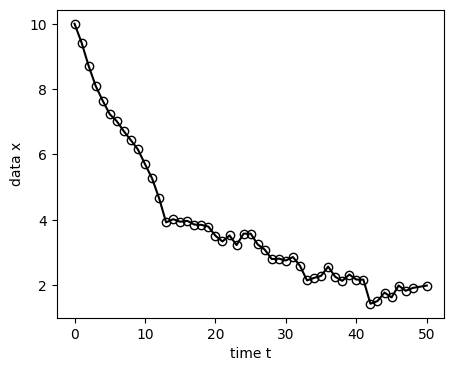

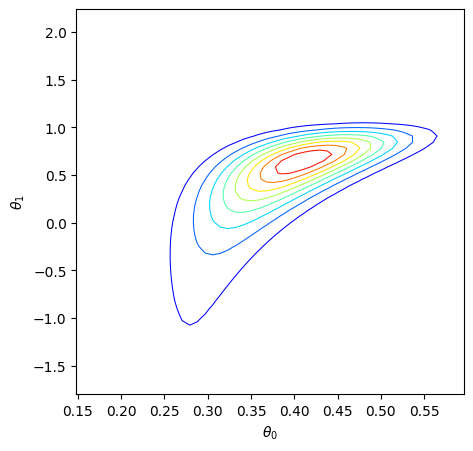

In [2]:
DIR = 'results/OP'                                             
RERUN = not utils_os.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_OP.OP_Problem(N=2000, n=50)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed data x_o
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
    
    # true samples theta ~ pi(theta|x_o)
    true_samples = problem.sample_from_true_posterior()
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    # load previously simulated true samples & x_o
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Visualize
problem.visualize()   
visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
plt.savefig('OP_true_posterior.png')

## Inference

### SMC-ABC

iteration  0
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  1
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  2
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  3
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  4
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  5
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  6
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  7
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  8
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  9
# of cpus =  4
> learning fake posterior 
fitting Gaussian copula progress= 0.0 loss= 202.45123291015625
fitting Gaussian copula progress= 0.1 loss= 20.40949058532715
fitting Gaussian copula progress= 0.2 loss= -206.81961059570312


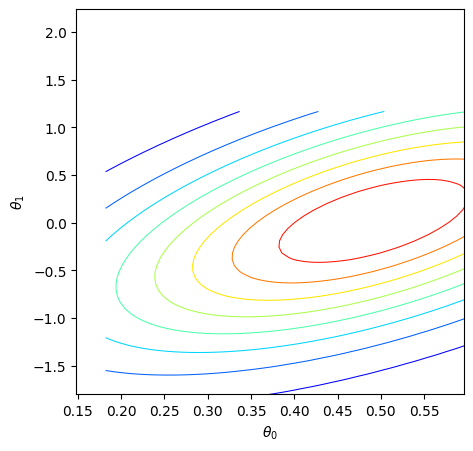

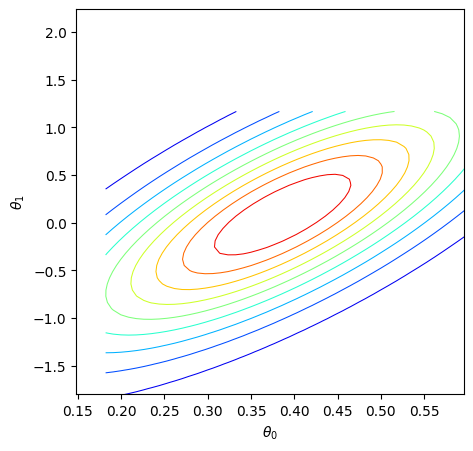

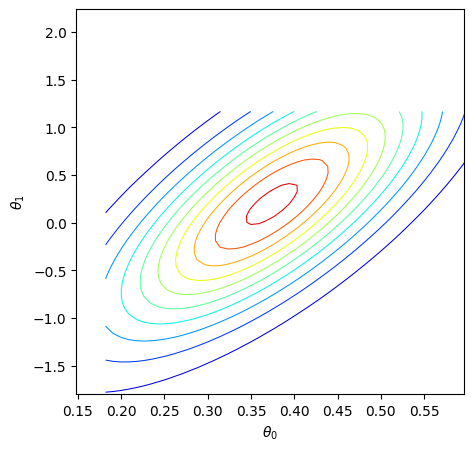

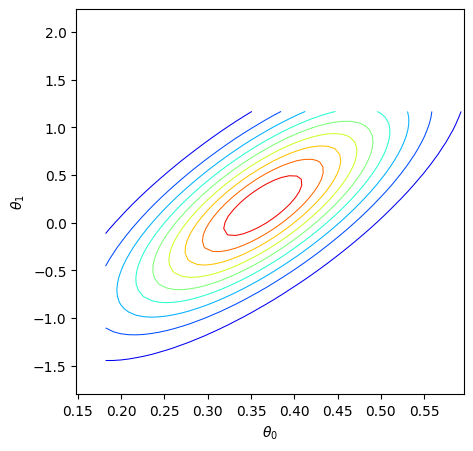

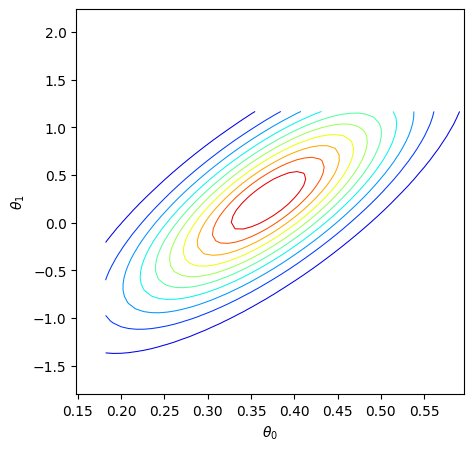

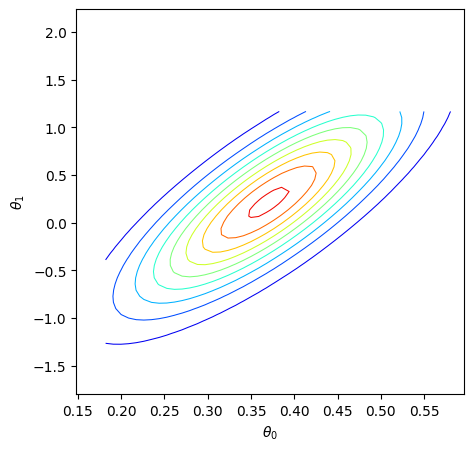

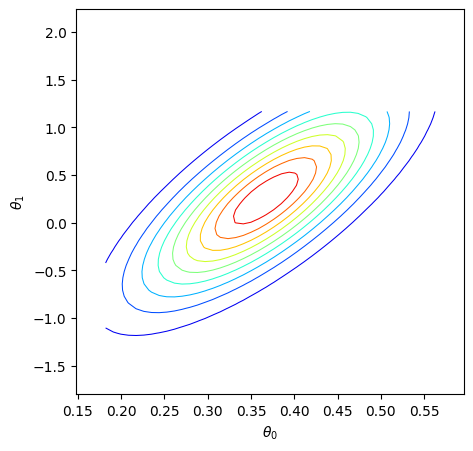

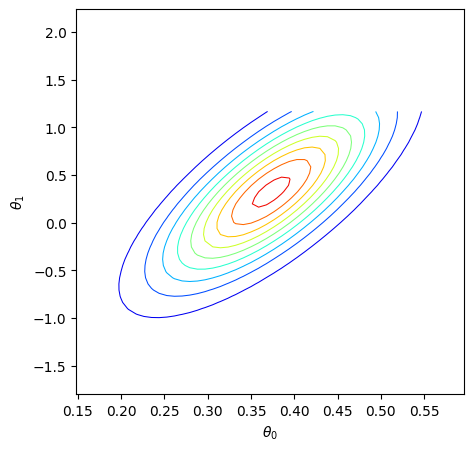

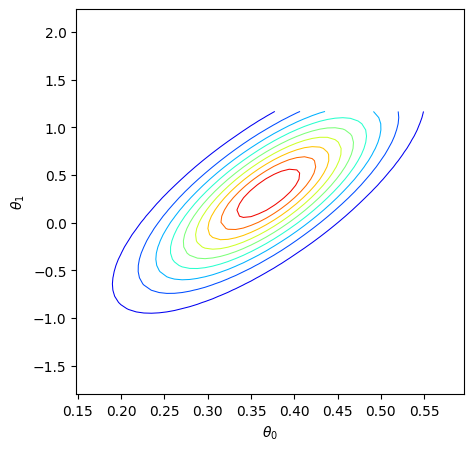

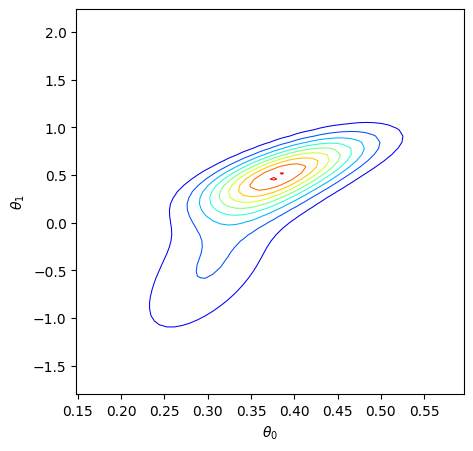

In [3]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 10                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SMC', JSD_smc_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 4 original dim = 50
architecture [50, 100, 100, 4]
finished: t= 0 loss= -0.04343591630458832 loss val= -0.045497264713048935 best loss -0.045497264713048935
finished: t= 200 loss= -0.24004846811294556 loss val= -0.29068514704704285 best loss -0.3285825550556183
finished: t= 400 loss= -0.011272807605564594 loss val= -0.011457831598818302 best loss -0.3876176178455353
finished: t= 600 loss= -0.06948105990886688 loss val= -0.08141056448221207 best loss -0.3876176178455353
finished: t= 800 loss= -0.011285902932286263 loss val= -0.012510444037616253 best loss -0.693198561668396
finished: t= 1000 loss= -0.00854563433676958 loss val= -0.008899667300283909 best loss -0.693198561668396
finished: t= 1200 loss= -0.007644474972039461 loss val= -0.007765011861920357 best loss -0.693198561668396
finished: t= 1400 loss= -0.016225093975663185 loss val= -0.016986684873700142 best loss -0.693198561668396
> learning fake posterior 
>

finished: t= 600 loss= -1.4341719150543213 loss val= -1.8719407320022583 best loss -2.1311559677124023
finished: t= 800 loss= -1.4564372301101685 loss val= -2.074699878692627 best loss -2.2952349185943604
finished: t= 1000 loss= -2.161964178085327 loss val= -1.9956015348434448 best loss -2.3409440517425537
finished: t= 1200 loss= -1.9662883281707764 loss val= -2.0284581184387207 best loss -2.5408096313476562
finished: t= 1400 loss= -1.7782888412475586 loss val= -2.2815165519714355 best loss -2.5418338775634766
finished: t= 1600 loss= -1.7995072603225708 loss val= -2.108215093612671 best loss -2.690920352935791
finished: t= 1800 loss= -1.8878605365753174 loss val= -2.356011152267456 best loss -2.690920352935791
> learning fake posterior 
> learning true posterior 


iteration  4
# of cpus =  4

 > fitting encoder
summary statistic dim = 4 original dim = 50
architecture [50, 100, 100, 4]
finished: t= 0 loss= -0.0963423103094101 loss val= -0.16833703219890594 best loss -0.1683370321989059

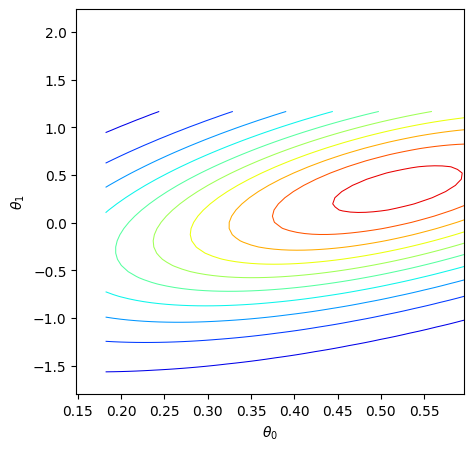

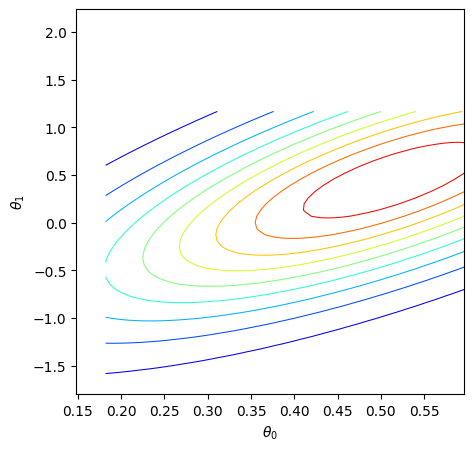

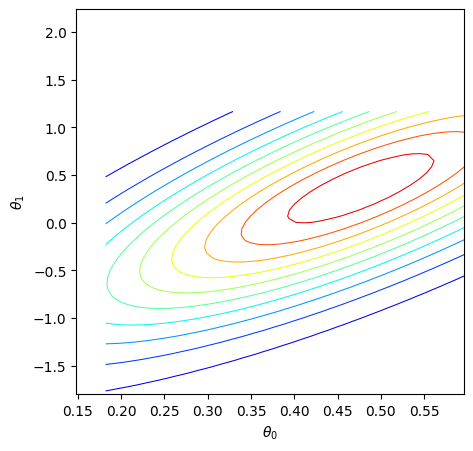

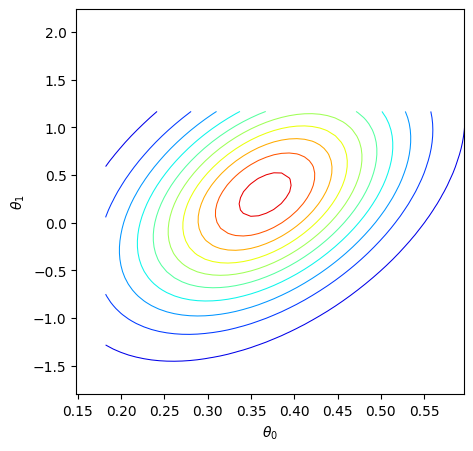

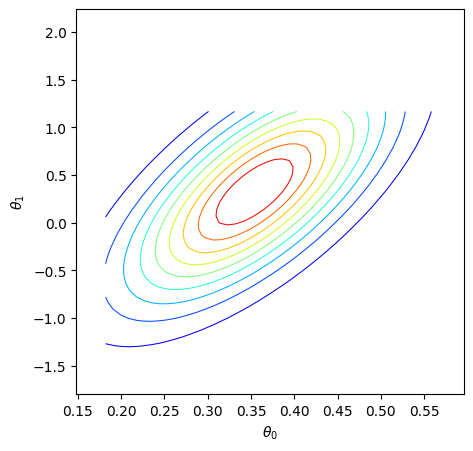

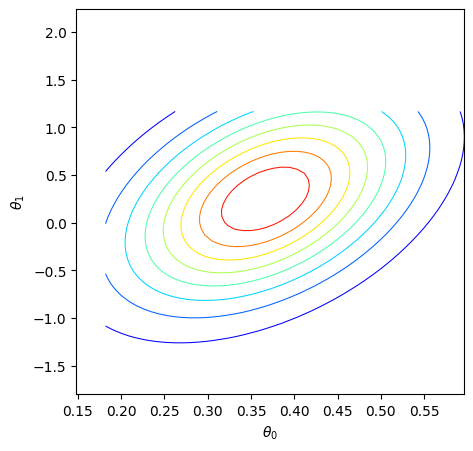

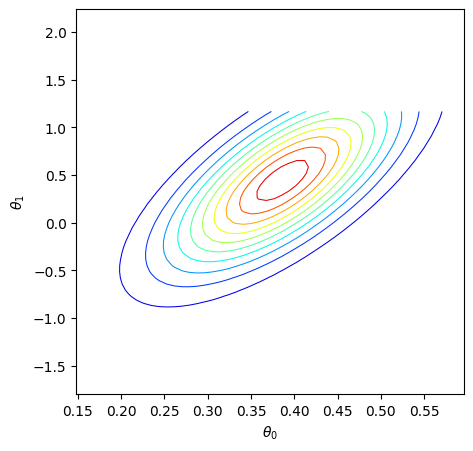

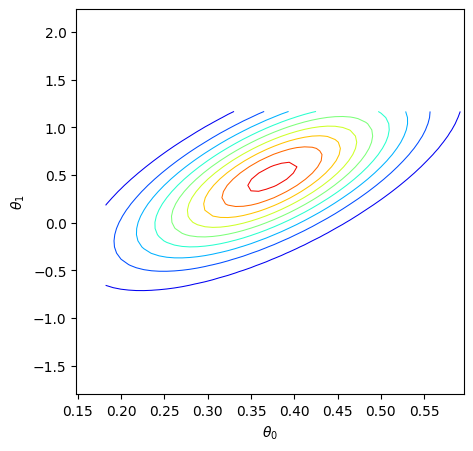

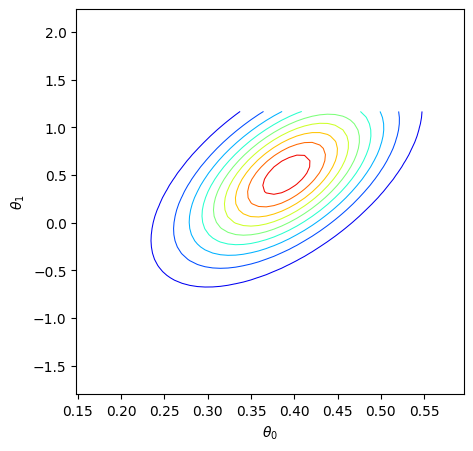

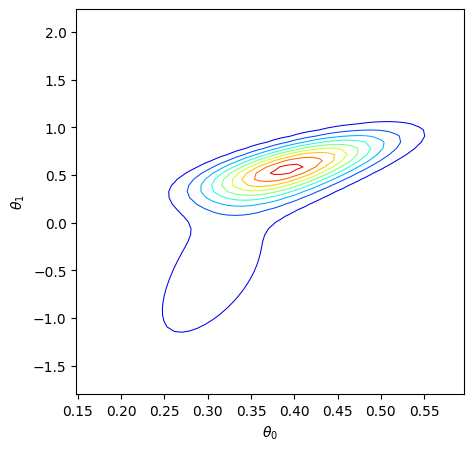

In [4]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'cnn1d'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score   
hyperparams.estimator = 'PREDEP'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SMC2', JSD_smc2_array)

### SNL


 SNL ABC
iteration  0
# of cpus =  4
finished: t= 0 loss= 811.9328002929688 loss val= 979.9822387695312 best loss 979.9822387695312
finished: t= 200 loss= 89.78565216064453 loss val= 97.14956665039062 best loss 97.14956665039062
finished: t= 400 loss= 49.145050048828125 loss val= 54.636383056640625 best loss 54.636383056640625
finished: t= 600 loss= 26.690542221069336 loss val= 33.96940994262695 best loss 33.11269760131836
finished: t= 800 loss= 17.144399642944336 loss val= 26.546234130859375 best loss 26.4006404876709
finished: t= 1000 loss= 12.404959678649902 loss val= 25.093536376953125 best loss 24.552648544311523
finished: t= 1200 loss= 9.63589859008789 loss val= 23.583032608032227 best loss 23.029050827026367
finished: t= 1400 loss= 7.991945743560791 loss val= 22.78278160095215 best loss 22.78278160095215
finished: t= 1600 loss= 4.824976921081543 loss val= 24.762718200683594 best loss 22.31222915649414
finished: t= 1800 loss= 7.160182952880859 loss val= 33.3701057434082 best los

finished: t= 0 loss= 787.759033203125 loss val= 815.1881713867188 best loss 815.1881713867188
finished: t= 200 loss= 27.2186279296875 loss val= 28.79248046875 best loss 27.834796905517578
finished: t= 400 loss= 12.29776668548584 loss val= 13.207147598266602 best loss 13.197425842285156
finished: t= 600 loss= 6.277145862579346 loss val= 10.342734336853027 best loss 8.579177856445312
finished: t= 800 loss= 2.54911732673645 loss val= 5.632131099700928 best loss 5.218956470489502
finished: t= 1000 loss= 0.25281602144241333 loss val= 3.740889072418213 best loss 3.740889072418213
finished: t= 1200 loss= -1.867576003074646 loss val= 3.144892454147339 best loss 2.9928901195526123
finished: t= 1400 loss= -2.8066446781158447 loss val= 2.6370625495910645 best loss 2.525409460067749
finished: t= 1600 loss= -3.6356101036071777 loss val= 3.041295289993286 best loss 2.3632283210754395
finished: t= 1800 loss= -4.434802055358887 loss val= 3.2645576000213623 best loss 2.1002566814422607


iteration  2
#

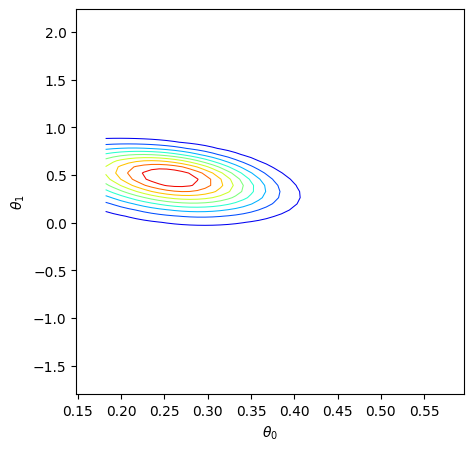

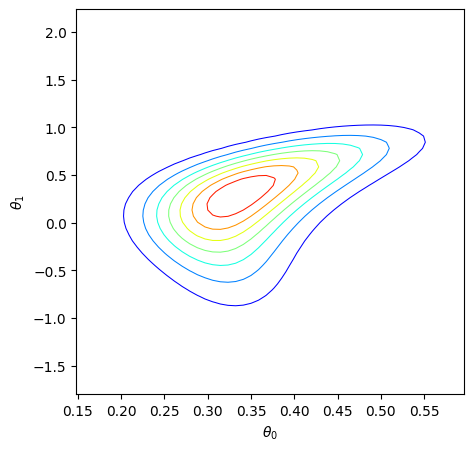

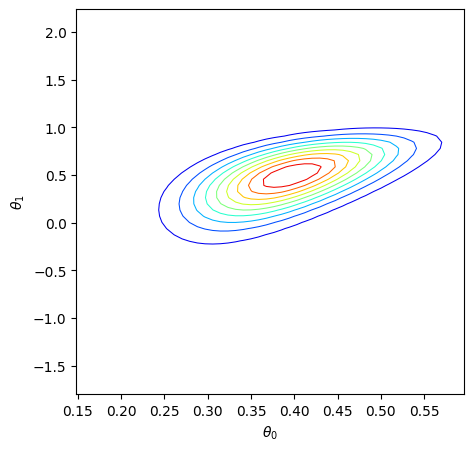

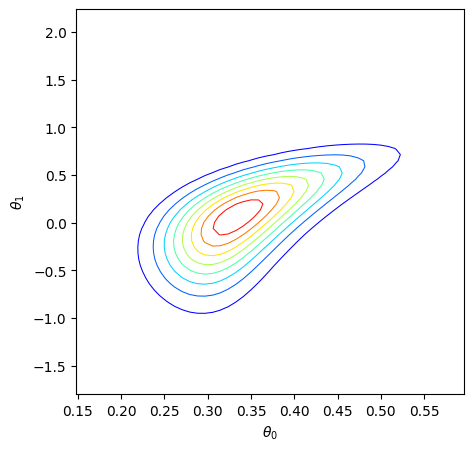

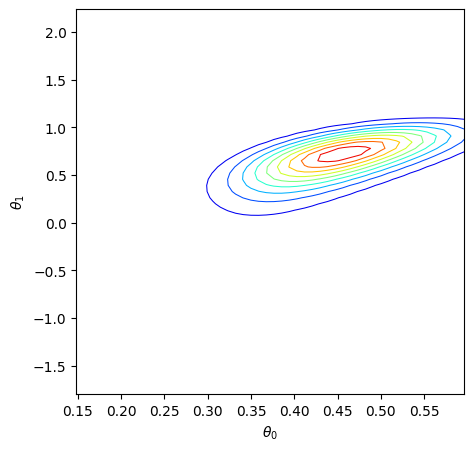

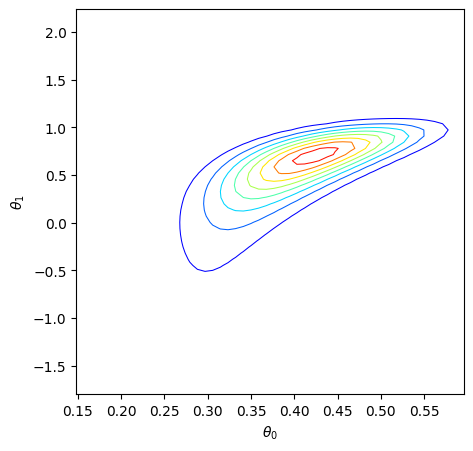

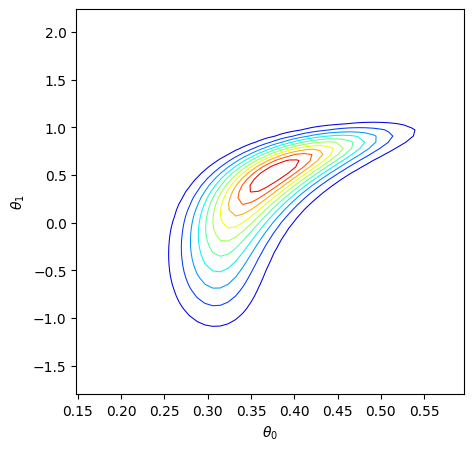

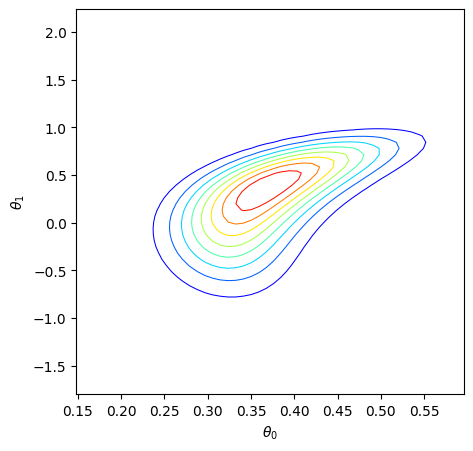

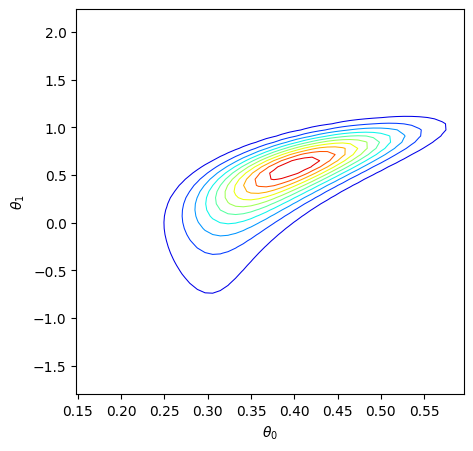

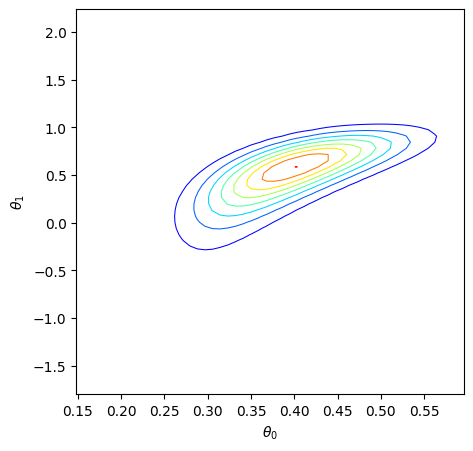

In [5]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000
hyperparams.L = 10

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SNL', JSD_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 4 original dim = 50
architecture [50, 100, 100, 4]
finished: t= 0 loss= -0.031394295394420624 loss val= -0.02707274630665779 best loss -0.02707274630665779
finished: t= 200 loss= -0.004896979779005051 loss val= -0.004669162444770336 best loss -0.4247334599494934
finished: t= 400 loss= -0.005172591656446457 loss val= -0.004782531410455704 best loss -0.4247334599494934
finished: t= 600 loss= -0.024476872757077217 loss val= -0.024127300828695297 best loss -0.4247334599494934
finished: t= 800 loss= -0.005451733246445656 loss val= -0.0049476525746285915 best loss -0.4247334599494934

 > fitting nde
all_stats.size() torch.Size([400, 4])
finished: t= 0 loss= 57.7182731628418 loss val= 64.62556457519531 best loss 64.62556457519531
finished: t= 200 loss= 3.6682403087615967 loss val= 3.7831947803497314 best loss 3.7831947803497314
finished: t= 400 loss= -0.3764663636684418 loss val= -0.2085115760564804 best loss -0.260993331

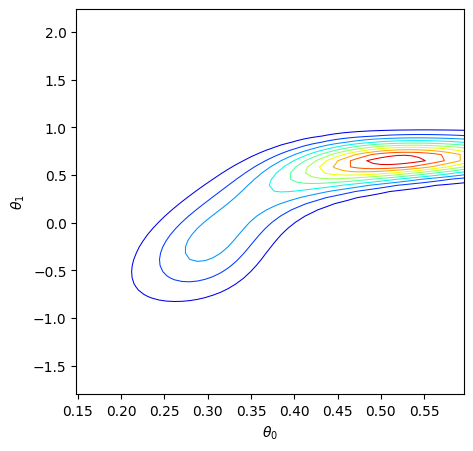

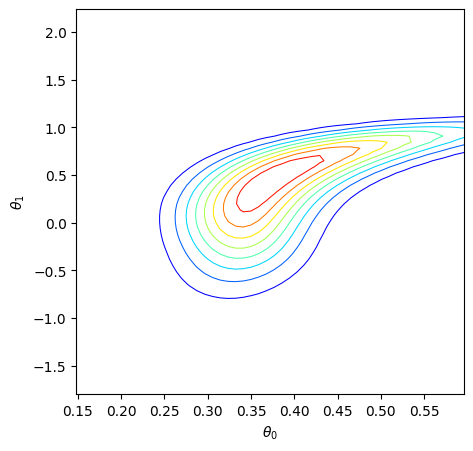

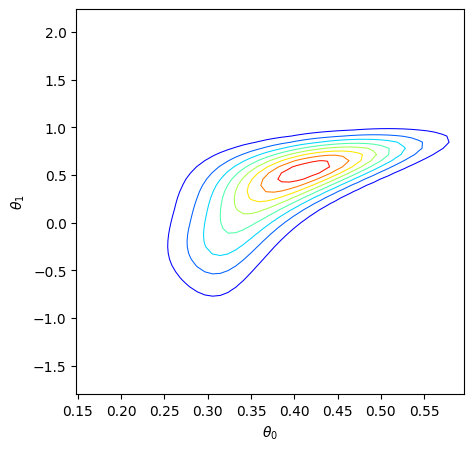

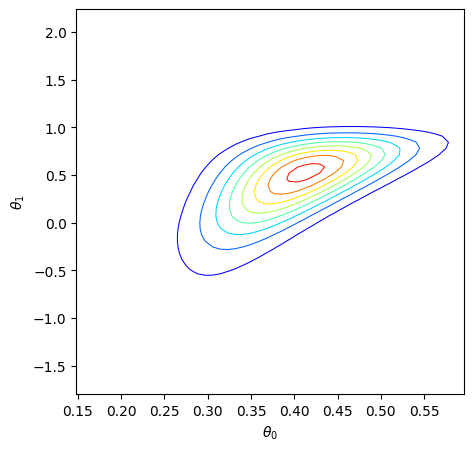

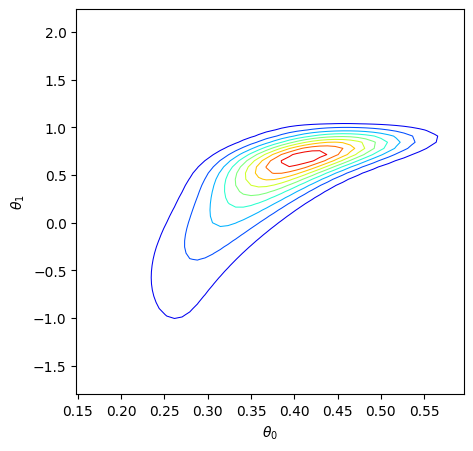

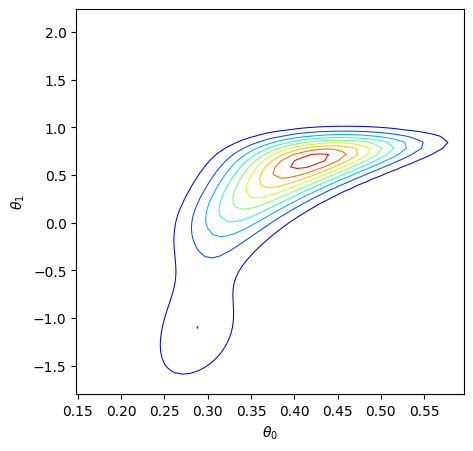

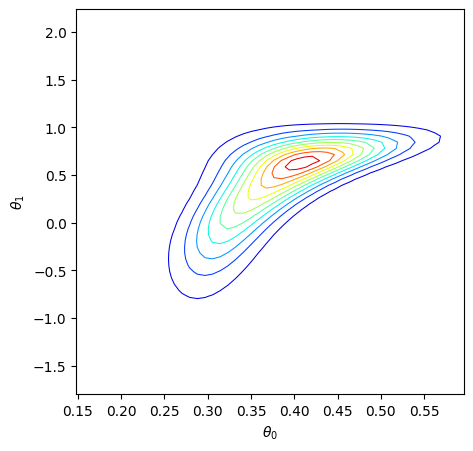

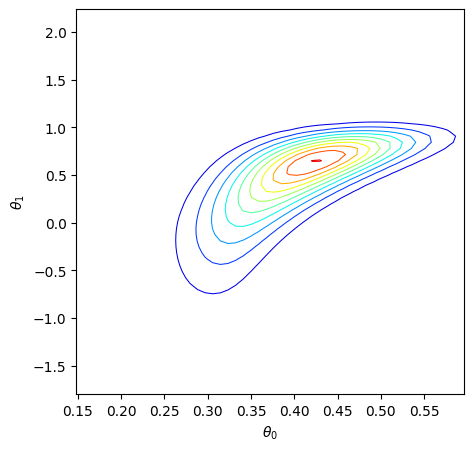

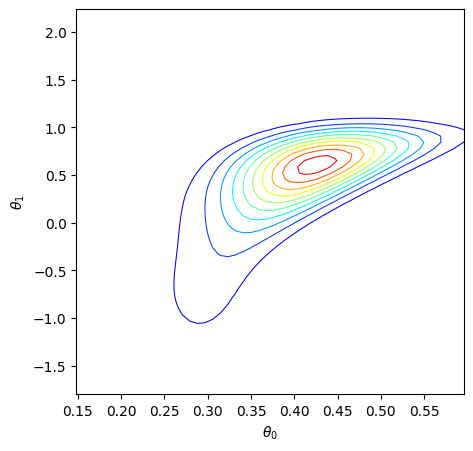

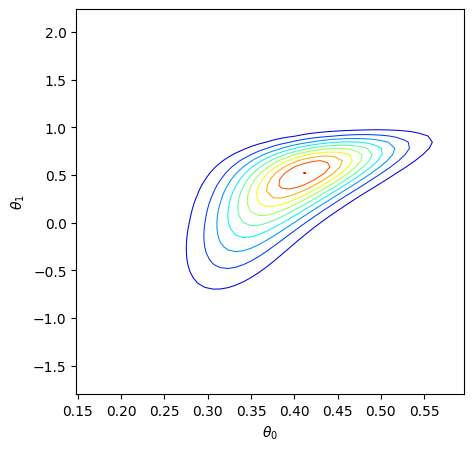

In [6]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'cnn1d'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score   
hyperparams.estimator = 'PREDEP'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SNL2', JSD_array)